# Final Exercice: The Rumos Bank (Decision Trees)

The Rumos Bank é um banco que tem perdido bastante dinheiro devido à quantidade de créditos que fornece e que não são pagos dentro do prazo devido. 

    - Por cada cliente que se estima que não irá  pagar dentro do prazo e afinal paga, o banco tem um custo de 1000euros. 

    - Por cada cliente que se prevê como sendo um bom pagador e afinal não paga dentro do prazo, o banco tem um custo de 3000euros.


Vocês, data scientists de topo,  são contratados para ajudar o banco a prever quais os clientes que não irão cumprir os prazos, para que este consiga uma melhor gestão dos fundos.

Conseguem construir um modelo que ajude a detectar previamente e com sucesso os clientes que são maus pagadores?


Dataset: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Variáveis disponíveis:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?
    3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?
    4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?
    5. Qual seria o custo que o banco tem sem nenhum modelo?
    6. Qual o custo que o banco passa a tar com o vosso modelo?

Com base na informação dada, podemos definir que:

    True positive - Os maus pagadores são identificados correctamente.
    True negative - Os bons pagadores são identificados correctamente.
    False positive - Um bom pagador é identificado como sendo um mau pagador.
    False negative - Um mau pagador é identificado como sendo um bom pagador.

In [56]:
# Import all necessary libraries
import mlflow

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

In [58]:
# Set the root path for data
ROOT_PATH = '../data/'
# Specify the target column name
TARGET_COL = "default.payment.next.month"
# Set the seed
SEED = 42

In [59]:
# Set the MLflow tracking URI to a SQLite database
mlflow.set_tracking_uri("sqlite:///../../mlruns/mlflow.db")

In [60]:
# Get the MLflow registry URI
mlflow.get_registry_uri()

'sqlite:///../../mlruns/mlflow.db'

In [61]:
# Import necessary module
from pathlib import Path
# Define the artifact location path
artifact_location = Path("../../mlruns/db")

# Create the folder '../../mlruns/db' if it doesn't exist
artifact_location.mkdir(parents=True, exist_ok=True)
# Specify the experiment name
experiment_name = 'Rumos Bank Prediction Final Project'
# Attempt to create the MLflow experiment with the specified name and artifact location
try:
    mlflow.create_experiment(name=experiment_name, artifact_location=artifact_location.as_posix())
except mlflow.MlflowException:
    # If the experiment already exists, catch the exception and proceed
    pass
# Set the active MLflow experiment to the specified experiment name
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///c:/Users/asus/Desktop/ml-course/sample-project/rumos/rumos_bank/notebooks/../../mlruns/db', creation_time=1701261323218, experiment_id='9', last_update_time=1701261323218, lifecycle_stage='active', name='Rumos Bank Prediction Final Project', tags={}>

In [62]:
# Start a new MLflow run
mlflow.start_run(run_name="Rumos Bank Decision Tree")

<ActiveRun: >

In [63]:
# Define the path to the lending data CSV file
df_path = ROOT_PATH + 'lending_data.csv'
# Define the path to the lending data CSV file
df_set = pd.read_csv(df_path)

In [64]:
# Display the shape of the DataFrame
df_set.shape

(30000, 25)

In [65]:
df_set.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [66]:
# Get the number of unique values in the 'ID' column
df_set.ID.nunique()

30000

#### 1. Quantas features estão disponíveis? Quantos clientes?

    - Existem 24 features disponíveis no dataset.
    - Existem 30000 clientes.

Existem missing values?

In [67]:
# Check if there are any missing values
df_set.isnull().values.any()

False

Existem o mesmo número de clientes nas duas classes?

In [68]:
# Group the DataFrame by the 'default.payment.next.month' column and count the occurrences of each group
df_set.groupby('default.payment.next.month')['default.payment.next.month'].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Não! O dataset é altamente desequilibrado.

#### 2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?

    - 23,364 foram bons pagadores. 6,636 foram maus pagadores.

Existem features não númericas?

In [69]:
# Display the data types of each column
df_set.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

Todas as features são númericas.

Vamos retirar o ID do cliente:

In [70]:
# Create a new DataFrame 'df' by dropping the 'ID' column from 'df_set'
df = df_set.drop('ID', axis = 1)

Vamos então dividir o dataset em treino e teste:

In [71]:
# Split the DataFrame 'df' into training and testing sets using train_test_split
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = SEED)

In [72]:
# Define file paths for the training and testing sets
train_path = ROOT_PATH + 'lending_train.csv'
test_path = ROOT_PATH + 'lending_test.csv'

In [73]:
# Save the training and testing sets to CSV files
train_set.to_csv('lending_train.csv', index=False)
test_set.to_csv('lending_test.csv', index=False)

In [74]:
# Read the training and testing sets from the saved CSV files
train_set = pd.read_csv('lending_train.csv')
test_set = pd.read_csv('lending_test.csv')

In [75]:
# Create MLflow datasets from Pandas DataFrames for training and testing sets
train_dataset = mlflow.data.from_pandas(train_set, source=train_path, targets=TARGET_COL, name="Lending Train Dataset")
test_dataset = mlflow.data.from_pandas(test_set, source=test_path, targets=TARGET_COL, name="Lending Test Dataset")

c:\Users\asus\miniconda3\envs\rumos-class-oml\lib\site-packages\mlflow\data\dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\asus\miniconda3\envs\rumos-class-oml\lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\asus\miniconda3\envs\rumos-class-oml\lib\site-packages\mlflow\data\dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\asus\miniconda3\envs\rumos-cla

In [76]:
# Log the seed parameter used in the experiment

mlflow.log_param("seed", SEED)

42

In [77]:
# Log the training and testing datasets as inputs in the "train" and "test" contexts
mlflow.log_input(train_dataset, context = "train")
mlflow.log_input(test_dataset, context = "test")

c:\Users\asus\miniconda3\envs\rumos-class-oml\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  return _infer_schema(self._df)


In [78]:
# Separate features and target variable for training set
X_train = train_set.drop([TARGET_COL], axis = 'columns')
y_train = train_set[TARGET_COL]
# Separate features and target variable for testing set
X_test = test_set.drop([TARGET_COL], axis = 1)
y_test = test_set[TARGET_COL]

Antes de iniciar, vamos calcular a baseline, ou seja, o custo que temos sem nenhum modelo.

$$totalCost = 1000∗FP+3000∗FN$$

In [79]:
# Create an array of predicted labels, assuming all predictions are "bad" (1)
y_preds_all_bad = np.ones(y_test.shape) 

In [80]:
# Calculate and print the elements of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


In [81]:
# Calculate and print the total cost based on the number of False Positives
print('Total Cost:', fp*1000)

Total Cost: 4687000


In [82]:
# Calculate and print the accuracy score
accuracy_score(y_test, y_preds_all_bad)

0.21883333333333332

Se todos os clientes fossem considerados como maus pagadores, o banco teria um custo de 4,687,000 Euros.

In [83]:
# Create an array of predicted labels, assuming all predictions are "good" (0)
y_preds_all_good = np.zeros(y_test.shape) 
# Calculate and print the elements of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


In [84]:
# Calculate the total cost based on the number of False Negatives
total_cost_baseline =  fn*3000

In [85]:
total_cost_baseline

3939000

In [86]:
mlflow.log_metric("total_cost_baseline", total_cost_baseline)

In [87]:
# Calculate the accuracy score
score_baseline = accuracy_score(y_test, y_preds_all_good)

In [88]:
score_baseline

0.7811666666666667

In [89]:
mlflow.log_metric("score_baseline", score_baseline)

Se todos os clientes fossem considerados bons pagadores, o banco teria um custo de 3,939,000 Euros.

In [90]:
# Define a function to calculate total cost based on the confusion matrix
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp
    

In [91]:
# Define a function to find the threshold with the minimum cost
def min_cost_threshold(y_test, y_preds):
    
    costs = {}
    # Iterate over thresholds from 0 to 1 with a step of 0.1
    for threshold in np.arange(0, 1.1, 0.1):
        
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)

     # Plot the costs at different thresholds    
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()
    

#### Model Pipeline

#### Decision Trees

In [92]:
# Define the name and hyperparameters for the Decision Tree model
model_name_dt = "decision_tree"

parameters_dt = {'dt__max_depth':[3, 6], 'dt__min_samples_split': [2, 4, 10]}

In [93]:
# Create a pipeline for the Decision Tree model
pipeline_dt = Pipeline([
    ('scaler', MinMaxScaler()),
    ('dt', tree.DecisionTreeClassifier(random_state = SEED,  class_weight = 'balanced'))
])


In [94]:
# Log the Decision Tree model name as a parameter in MLflow
mlflow.log_param("model_name_dt", model_name_dt)

'decision_tree'

In [95]:
# Use GridSearchCV to find the best hyperparameters for the Decision Tree model
clf_dt = GridSearchCV(pipeline_dt, parameters_dt, cv =5).fit(X_train, y_train)

In [96]:
# Log the best hyperparameters found by GridSearchCV for the Decision Tree model in MLflow
mlflow.log_params(clf_dt.best_params_)

In [97]:
# Log the best-performing Decision Tree model using MLflow
mlflow.sklearn.log_model(clf_dt, artifact_path="grid_search_cv_dt")

c:\Users\asus\miniconda3\envs\rumos-class-oml\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\asus\miniconda3\envs\rumos-class-oml\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [98]:
# Extract the best-performing Decision Tree pipeline from the GridSearchCV result
tunned_dt_pipeline = clf_dt.best_estimator_

In [99]:
# Log the tuned Decision Tree pipeline as a registered model in MLflow
mlflow.sklearn.log_model(tunned_dt_pipeline, "tunned_dt_pipeline", registered_model_name="decision_tree")

Successfully registered model 'decision_tree'.
2023/11/29 13:52:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: decision_tree, version 1
Created version '1' of model 'decision_tree'.


In [100]:
# Get the parameters of the tuned Decision Tree pipeline
tunned_dt_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('dt',
   DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'dt': DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': 'balanced',
 'dt__criterion': 'gini',
 'dt__max_depth': 3,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

In [101]:
# Calculate the accuracy score of the tuned Decision Tree model on the test set
score_dt = clf_dt.score(X_test, y_test)

In [102]:
score_dt

0.7608333333333334

In [103]:
# Log score as a metric in MLflow
mlflow.log_metric("score_dt", score_dt)

In [104]:
# Make probability predictions using the tuned Decision Tree pipeline on the test set
y_preds = tunned_dt_pipeline.predict_proba(X_test)[:,1]

In [105]:
# Calculate and print the total cost based on the tuned Decision Tree predictions
total_cost(y_test, y_preds, threshold = 0.5)

2581000

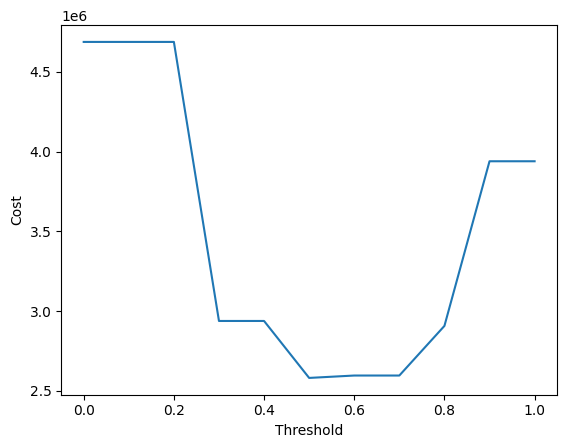

In [106]:
# Find and visualize the threshold with the minimum cost for the tuned Decision Tree predictions
min_cost_threshold(y_test, y_preds)

In [107]:
# Calculate and store the total cost based on the tuned Decision Tree predictions with a specific threshold
total_cost_res_dt = total_cost(y_test, y_preds, threshold = 0.5)

In [108]:
total_cost_res_dt

2581000

In [109]:
# Log the total cost as a metric in MLflow
mlflow.log_metric("total_cost_dt", total_cost_res_dt)

In [110]:
mlflow.end_run()